<a href="https://colab.research.google.com/github/anushapalisetty/Intel-Image-Classification/blob/main/Densnet2_Git_Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import cv2
import pandas as pd




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Image Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
#     zoom_range=0.2, validation_split=0.1)
train_datagen = ImageDataGenerator(horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.1)
"""train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.01,
      zoom_range=[0.1, 1.5],
      horizontal_flip=True,
      fill_mode='nearest',
      zca_whitening=True,
      brightness_range=[0.1, 2]
)"""


train_generator=train_datagen.flow_from_directory(
     '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training'
    
)

validation_generator=train_datagen.flow_from_directory(
      '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation'
    
)

#test_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_test/seg_test/', 
    target_size=(150,150),
    batch_size=64,
    class_mode='sparse',
    seed=2209
) 

test1_datagen = ImageDataGenerator()
test1_generator = test1_datagen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_test/seg_test/', 
    target_size=(150,150),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=2209
) 

Found 12667 images belonging to 6 classes.
Found 1406 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# **DenseNet121**

In [6]:
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import numpy as np 
from keras.applications.densenet import DenseNet121
import keras


base_model1=DenseNet121(include_top=False, weights= 'imagenet',  input_shape=(150,150,3), pooling='avg')
base_model1.trainable = False

x = Dense(256, activation='relu')(base_model1.output)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

transfer_model1 = Model(base_model1.input, x) 
transfer_model1.compile(optimizer =keras.optimizers.SGD(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

29089792/29084464 [==============================] - 2s 0us/step


In [7]:
import tensorflow as tf
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
history2 = transfer_model1.fit_generator(
            train_generator,
            steps_per_epoch=int(12667 /64),
            epochs=60,
            validation_data=validation_generator,
            validation_steps=int(1406 /64),
            callbacks=[reduce],
            verbose=1)
transfer_model1.save('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_Dense_Git_4.hd5')


import pandas as pd
df_cnn = pd.DataFrame(history2.history)      
# saving the dataframe  
df_cnn.to_csv('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_Dense_Git_4_History.csv')  


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
197/197 [==============================] - 6558s 33s/step - loss: 5.8754 - accuracy: 0.3041 - val_loss: 2.0854 - val_accuracy: 0.4643
Epoch 2/60
197/197 [==============================] - 83s 423ms/step - loss: 3.5072 - accuracy: 0.3870 - val_loss: 1.5023 - val_accuracy: 0.5432
Epoch 3/60
197/197 [==============================] - 84s 425ms/step - loss: 2.5875 - accuracy: 0.4283 - val_loss: 1.2921 - val_accuracy: 0.5722
Epoch 4/60
197/197 [==============================] - 82s 418ms/step - loss: 2.0825 - accuracy: 0.4560 - val_loss: 1.1793 - val_accuracy: 0.5826
Epoch 5/60
197/197 [==============================] - 83s 421ms/step - loss: 1.8141 - accuracy: 0.4735 - val_loss: 1.1254 - val_accuracy: 0.5938
Epoch 6/60
197/197 [==============================] - 83s 423ms/step - loss: 1.6403 - accuracy: 0.4954 - val_loss: 1.0878 - val_accuracy: 0.6027
Epoch 7/60
197/197 [==============================] - 

In [8]:
import tensorflow as tf
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
#accuracy=model1.evaluate_generator(test_generator)
accuracy=transfer_model1.evaluate(test_generator,steps=len(test_generator)//32,callbacks=[reduce],verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

1/1 - 0s - loss: 0.7585 - accuracy: 0.7812
Accuracy of the model on the test set:  0.78125


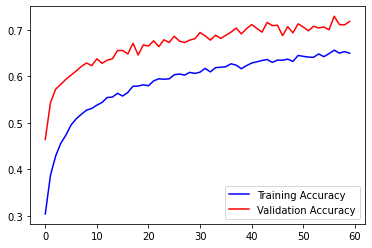

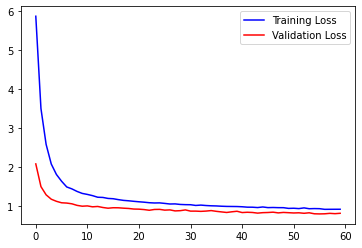

In [11]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [12]:

import keras
#model1 = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model.hd5')
model2 = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_Dense_Git_4.hd5')

In [15]:
import tensorflow as tf
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
#accuracy=model1.evaluate_generator(test_generator)
accuracy=transfer_model1.evaluate(test_generator,steps=len(test_generator)//32,callbacks=[reduce],verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

1/1 - 0s - loss: 1.0568 - accuracy: 0.6250
Accuracy of the model on the test set:  0.625


In [16]:
import os
path = '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/'
images = []

x = os.listdir("/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/")

for i in x:
    img = path + i
    images.append(img)
  

labels = {
    0 : "buildings" , 
    1 : "forest" , 
    2 : "glacier" , 
    3 : "mountain" , 
    4 : "sea" , 
    5 : "street"
}

from tensorflow.keras.preprocessing import image

outputs = []
ids = []
for i in images:
    img = image.load_img(i , target_size = (150,150))
    img = image.img_to_array(img)
    img = np.expand_dims(img , axis=0)
    c = transfer_model1.predict([img])
    pred_labels = np.argmax(c, axis = 1)
    la = labels[pred_labels[0]]
    
    outputs.append(la)
    ids.append(i)
import pandas as pd
data = pd.DataFrame({
    "Image" : ids , 
    "Label" : outputs
})

In [18]:
data.Label.value_counts()

forest       1516
sea          1358
mountain     1319
buildings    1114
glacier      1053
street        944
Name: Label, dtype: int64

In [32]:
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/georgia-state-university-1.png'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Cali_street.jpg'
img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Pooru-Mountain.jpeg'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Meg_Sea.jpg'

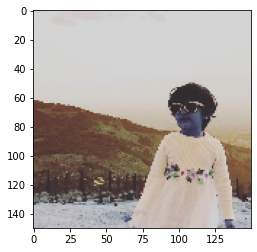

In [33]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img=cv2.imread(img)
img=cv2.resize(img,(150,150))
plt.imshow(img.reshape([150,150,3]))
img = np.reshape(img,[1,150,150,3])

In [34]:
transfer_model1.predict(img).round(2)

array([[0.15, 0.01, 0.36, 0.27, 0.16, 0.05]], dtype=float32)

In [31]:
model2.predict(img).round(2)

array([[0.04, 0.01, 0.14, 0.65, 0.16, 0.  ]], dtype=float32)

In [ ]:
classes1=['buildings', 'forest' , 'glacier' , 'mountain', 'sea', 'street']